#Load the data in google colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls '/content/gdrive/MyDrive'

'Colab Notebooks'   FANG_News.csv   sample_texts.csv   Smith


In [3]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/FANG_News.csv", sep=None,engine='python')
df.head(2)

,Ticker,MonthEnd,Summary
0,AMZN,2018-08-31,MEXICO CITY (Reuters) - Amazon.com Inc will be...
1,AMZN,2018-09-30,BRUSSELS (Reuters) - EU antitrust regulators a...


#Preprocessing steps

1. First, convert the column “MonthEnd” to a pandas datetime column

In [4]:
def get_monthend(date):
  return pd.to_datetime(date)

df["MonthEnd"] = df["MonthEnd"].apply(get_monthend) 
df.head(2)

,Ticker,MonthEnd,Summary
0,AMZN,2018-08-31,MEXICO CITY (Reuters) - Amazon.com Inc will be...
1,AMZN,2018-09-30,BRUSSELS (Reuters) - EU antitrust regulators a...


2. Second, create a new column, sentences, that is a list of tokenized sentences using the NLTK.tokenize.sent_tokenize method

In [5]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
df['sentences'] = df.apply(lambda row: nltk.sent_tokenize(row['Summary']), axis=1)
df.head(2)

,Ticker,MonthEnd,Summary,sentences
0,AMZN,2018-08-31,MEXICO CITY (Reuters) - Amazon.com Inc will be...,[MEXICO CITY (Reuters) - Amazon.com Inc will b...
1,AMZN,2018-09-30,BRUSSELS (Reuters) - EU antitrust regulators a...,[BRUSSELS (Reuters) - EU antitrust regulators ...


3. Third, preprocess the sentences column and call the new column clean_tokens.Remove non-alphabetic characters, lowercase each token, remove stopwords, and omit any empty sentences. The final product for this column should be a list of lists. Each list is one sentence, and each sentence has been tokenized and cleaned for the above.

In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def generate_tokens(sentence_list):
    final_tokens = []
    for sentence in sentence_list:
        new_text = re.sub("[^A-Za-z]"," ", sentence)
        tokens = new_text.lower().split()
        tokens = [el for el in tokens if el not in sw]
        if tokens!=[]:
            final_tokens.append(tokens)
    return final_tokens

sw = set(stopwords.words("english"))
df["clean_tokens"] = df.sentences.apply(generate_tokens)
df.head(2)

,Ticker,MonthEnd,Summary,sentences,clean_tokens
0,AMZN,2018-08-31,MEXICO CITY (Reuters) - Amazon.com Inc will be...,[MEXICO CITY (Reuters) - Amazon.com Inc will b...,"[[mexico, city, reuters, amazon, com, inc, beg..."
1,AMZN,2018-09-30,BRUSSELS (Reuters) - EU antitrust regulators a...,[BRUSSELS (Reuters) - EU antitrust regulators ...,"[[brussels, reuters, eu, antitrust, regulators..."


[10 pts] Find the number of tokens for each Ticker-MonthEnd observation. That is, for the list of list variable you defined above, create a new column that reports the length (the number of cleaned tokens there are over all sentences for that Ticker-MonthEnd observation.

In [9]:
def word_count(splitwords):
  wordcounts = sum([len(words) for words in splitwords])
  return(wordcounts)

df['word_count'] = df.clean_tokens.apply(word_count)
df.head(2)

,Ticker,MonthEnd,Summary,sentences,clean_tokens,word_count
0,AMZN,2018-08-31,MEXICO CITY (Reuters) - Amazon.com Inc will be...,[MEXICO CITY (Reuters) - Amazon.com Inc will b...,"[[mexico, city, reuters, amazon, com, inc, beg...",92
1,AMZN,2018-09-30,BRUSSELS (Reuters) - EU antitrust regulators a...,[BRUSSELS (Reuters) - EU antitrust regulators ...,"[[brussels, reuters, eu, antitrust, regulators...",853


#Deploy Model

[10 pts] Estimate a Word2Vec model with dimension size 100, skip gram model, window size of  10, and the min_count set to 1 for the cleaned_tokens column.

In [10]:
from gensim.models import Word2Vec

In [11]:
model = Word2Vec(df["clean_tokens"].sum(), size=10, sg=1,window=10, min_count=1, seed=1234)

[20 pts] For each of the four words (coronavirus; privacy; retail; 
streaming), find the 10 words that are most similar according to the word embeddings (using the “most_similar” function from the gensim model). Create a regex pattern that you will use in a couple steps to count the frequency of all of those words. The pattern should be “word1|word2|word3…|word10”, that is, each word separated by the pipe “|”.

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [13]:
# Get list of words for annotation of the scatter plot
vocab = list(model.wv.vocab)
X = model[vocab]

# Project them onto the 2 Dimensional space
tsne = TSNE(n_components=2,random_state=1234)
X_tsne = tsne.fit_transform(X)
# Create a DataFrame with words as index, and
# 2 dimensions as main columns (x-axis, y-axis)
scatter_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Annotate the figure
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(scatter_df['x'], scatter_df['y'])

# Annotate each point with its word
for word, pos in scatter_df.iterrows():
    ax.annotate(word, pos)
#plt.show() #Displays very cluttered 2D chart

In [15]:
#coronavirus
print(model.wv.most_similar(positive=["coronavirus"], topn=10))

[('customers', 0.9908720254898071), ('pandemic', 0.9831258058547974), ('home', 0.9829450249671936), ('deliver', 0.9823774099349976), ('grocery', 0.9817191958427429), ('outbreak', 0.9812354445457458), ('workers', 0.9810481667518616), ('packages', 0.978001594543457), ('orders', 0.9669379591941833), ('warehouse', 0.9669297337532043)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [16]:
#privacy
print(model.wv.most_similar(positive=["privacy"], topn=10))

[('concerns', 0.9484697580337524), ('regulators', 0.9417887926101685), ('regulatory', 0.9274253845214844), ('practices', 0.9231371879577637), ('scrutiny', 0.9171626567840576), ('digital', 0.9121741056442261), ('protection', 0.9055114984512329), ('european', 0.9036614298820496), ('user', 0.8968291282653809), ('consumer', 0.8912631273269653)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [17]:
#retail
print(model.wv.most_similar(positive=["retail"], topn=10))

[('indian', 0.9810417890548706), ('bengaluru', 0.9768139719963074), ('party', 0.9749400019645691), ('buy', 0.96812504529953), ('reliance', 0.9644782543182373), ('india', 0.9615175127983093), ('ltd', 0.9602711796760559), ('sellers', 0.9590660929679871), ('stake', 0.9569718837738037), ('e', 0.9558642506599426)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [18]:
#streaming
print(model.wv.most_similar(positive=["streaming"], topn=10))

[('angeles', 0.9318888187408447), ('prime', 0.9278261661529541), ('one', 0.9270071983337402), ('shoppers', 0.9265050292015076), ('disney', 0.9259935617446899), ('pandemic', 0.921895444393158), ('netflix', 0.9101477861404419), ('home', 0.9059743881225586), ('coronavirus', 0.905280351638794), ('los', 0.9051663279533386)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [19]:
#All in one
similar_to_string =["coronavirus","privacy","retail","streaming"]
res=[]
for word in similar_to_string:
  res.append(model.wv.most_similar(positive=[word], topn=10))

#res.shape()

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [20]:
def coronavirus_words(sent):
    return re.findall('(pandemic|workers|home|outbreak|customers|one|roared|deliver|stores|due)', sent)

def privacy_words(sent):
    return re.findall('(concerns|regulators|brussels|user|practices|eu|facebook|personal|instagram|commissioner)', sent)

def retail_words(sent):
    return re.findall('(indian|stake|buy|india|reliance|ltd|bengaluru|investment|industries|partnership)', sent)

def streaming_words(sent):
    return re.findall('(video|prime|netflix|customers|disney|paris|angeles|shopping|grocery|supermarket)', sent)

[5 pts] Generate a new column that is the lowercase of the Summary column and call it Summary_lc

In [21]:
df['Summary_lc']= df['Summary'].str.lower()

[15 pts] For each word, count the frequency of each word group. That is, what is the frequency (counts over total cleaned tokens) for all the words that are similar to coronavirus, privacy, retail, and streaming.

In [22]:
df['coronavirus_words'] = df['Summary_lc'].apply(coronavirus_words)
df['coronavirus_word_counts'] = df.coronavirus_words.apply(word_count)

df['privacy_words'] = df['Summary_lc'].apply(privacy_words)
df['privacy_word_counts'] = df.privacy_words.apply(word_count)

df['retail_words'] = df['Summary_lc'].apply(retail_words)
df['retail_word_counts'] = df.retail_words.apply(word_count)

df['streaming_words'] = df['Summary_lc'].apply(streaming_words)
df['streaming_word_counts'] = df.streaming_words.apply(word_count)

df.head(3)

,Ticker,MonthEnd,Summary,sentences,clean_tokens,word_count,Summary_lc,coronavirus_words,coronavirus_word_counts,privacy_words,privacy_word_counts,retail_words,retail_word_counts,streaming_words,streaming_word_counts
0,AMZN,2018-08-31,MEXICO CITY (Reuters) - Amazon.com Inc will be...,[MEXICO CITY (Reuters) - Amazon.com Inc will b...,"[[mexico, city, reuters, amazon, com, inc, beg...",92,mexico city (reuters) - amazon.com inc will be...,[],0,"[eu, eu, eu]",6,[],0,[],0
1,AMZN,2018-09-30,BRUSSELS (Reuters) - EU antitrust regulators a...,[BRUSSELS (Reuters) - EU antitrust regulators ...,"[[brussels, reuters, eu, antitrust, regulators...",853,brussels (reuters) - eu antitrust regulators a...,"[one, deliver, deliver, one, stores, stores, c...",69,"[brussels, eu, eu, regulators, eu, eu, eu, eu,...",139,"[indian, investment, stake, indian, indian, bu...",51,"[supermarket, customers, video, video, grocery]",37
2,AMZN,2018-10-31,(Reuters) - EBay Inc beat analysts' estimates...,[(Reuters) - EBay Inc beat analysts' estimate...,"[[reuters, ebay, inc, beat, analysts, estimate...",919,(reuters) - ebay inc beat analysts' estimates...,"[one, one, one, home, deliver, deliver, deliver]",34,"[eu, eu, eu, eu, eu, concerns, eu, eu, concern...",118,"[investment, investment, buy, stake, india, lt...",109,"[netflix, supermarket, paris, supermarket, pri...",75


[20 pts] For each word group, plot the frequencies over time of the 4 companies. You should have 4 graphs, one for each word group. On each graph, there should be 4 lines, one for each company.

[10 pts] Interpret the graphs. Which companies are discussed more in the context of all the coronavirus words, privacy words, etc.?

In [23]:
df_grouped=df.groupby(['MonthEnd','Ticker']).sum(['coronavirus_word_counts','privacy_word_counts','retail_word_counts','streaming_word_counts'])
#df_grouped

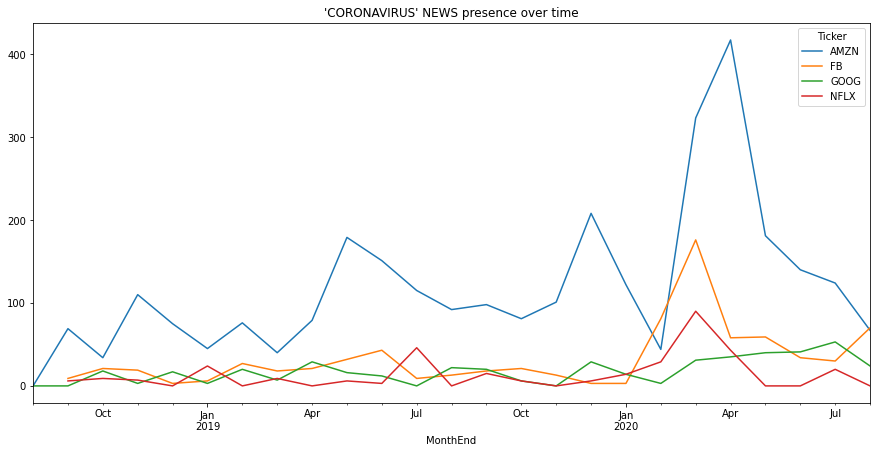

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title("'CORONAVIRUS' NEWS presence over time")
df_grouped['coronavirus_word_counts'].unstack().plot(ax=ax)

Amazon has the highest coronavirus related news, followed by facebook and then Netflix and finally google. As shown in the graph, there's a spike during the March-June period, when the world was getting to know about the lockdown i.e. 'new-normal'

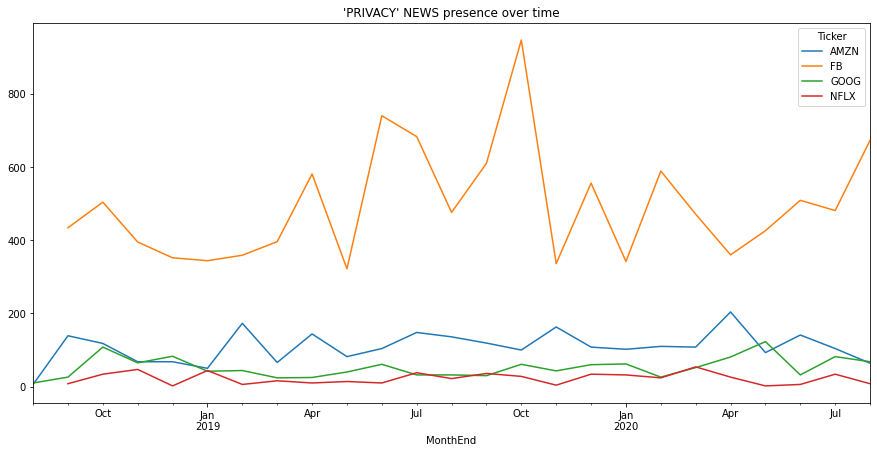

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title("'PRIVACY' NEWS presence over time")
df_grouped['privacy_word_counts'].unstack().plot(ax=ax)

Facebook is associated with higher 'privacy' related sentiment in the news . This is true because Facebook has been assoicated with anti-trust scandals in the past. Eg: 'FACEBOOK-CAMBRIDGE ANALYTICA DATA SCANDAL' which brought forth a congressional hearing to evaluate the role of social media (data theft) in the rigging of 2016 US Presidential Elections

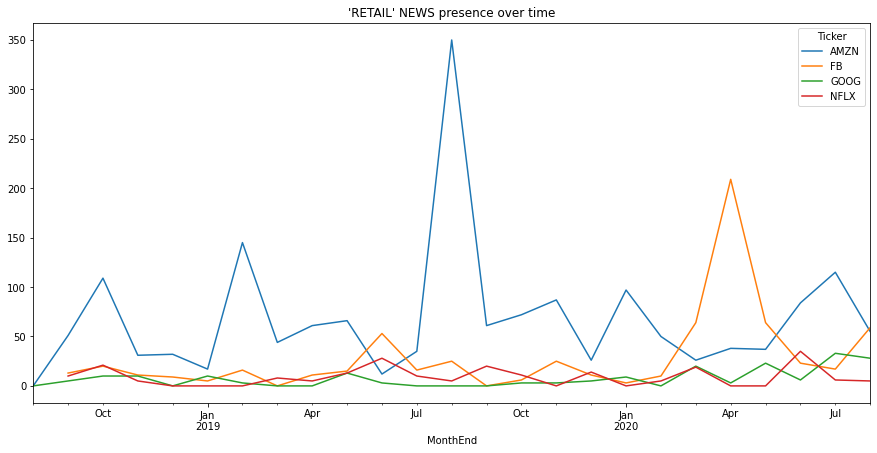

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title("'RETAIL' NEWS presence over time")
df_grouped['retail_word_counts'].unstack().plot(ax=ax)

Obviously Amazon, a retail gaint has a greater sentiment towards retail-related news. There was a spike in the July-September season in 2019. Surprisingly, facebook has been making waves recently. This can be attributed to facebook marketplace which is a one-stop solution for all new/used buying needs. Social media marketing and e-commerce has picked up wind. Moreover, due to an increased demand of goods people are shifting to alternate ways to obtain the things they need.

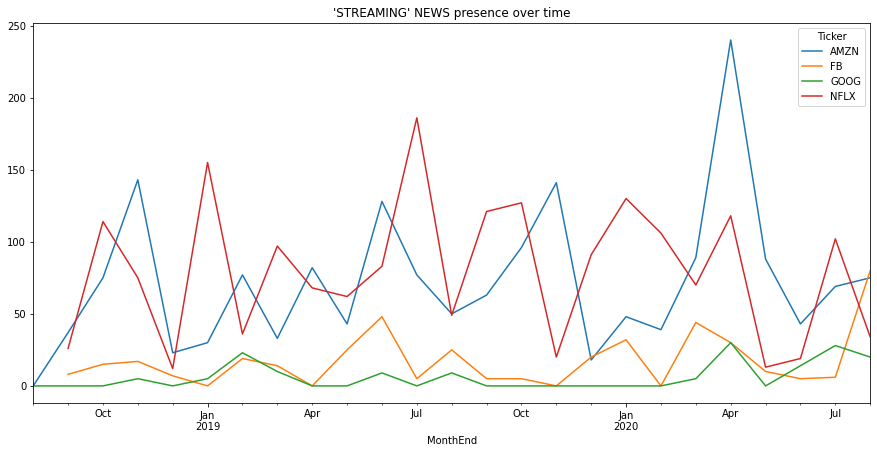

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title("'STREAMING' NEWS presence over time")
df_grouped['streaming_word_counts'].unstack().plot(ax=ax)

Video on demand has become a trend in today's fast paced life. People prefer watching movies when they have the time and not when cinema theatres or movie halls have shows. Netflix and Amazon Prime Videos are two big players in this market. They have captured a large portion of the market segment. However, with audio & video media being created in a large quantity every second (using CGI, VFX, 24-FPS, Rendering etc) there are other players in the market that FANG companies need to compete with. Some examples are Disney, Hulu, Sony, etc.

Although the consumption of movies and e-media has gone up during the pandemic. News regarding these media houses hasn't fluctuated much. As shown in the graph above.